In [1]:
!pip install scanf

!pip install igraph

In [2]:
import copy
import igraph
from igraph import Graph
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import softmax
import time

import data_handler as dh
from utils import find_all_paths, calculate_new_cost, get_path_cost, get_gumbel_values


# Braess example

In [3]:
net_name = 'Braess_net.tntp'
trips_name = 'Braess_trips.tntp'

N = 10000

In [4]:
handler = dh.DataHandler() 
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time', 'b', 'power'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()


,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time,b,power
0,1,True,3,True,1.0,1.000000e-08,1.000000e+09,1.0
1,1,True,4,True,1.0,5.000000e+01,2.000000e-02,1.0
2,3,True,2,True,1.0,5.000000e+01,2.000000e-02,1.0
3,3,True,4,True,1.0,1.000000e+01,1.000000e-01,1.0
4,4,True,2,True,1.0,1.000000e-08,1.000000e+09,1.0


In [5]:
gr = graph_data['graph_table']

## Start point

In [6]:
gr['flow'] = 0
gr.loc[0, ['flow']] =  N 
gr.loc[2, ['flow']] =  N
gr['cost'] = 0.


In [7]:
gr.head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time,b,power,flow,cost
0,1,True,3,True,1.0,1.000000e-08,1.000000e+09,1.0,10000,0.0
1,1,True,4,True,1.0,5.000000e+01,2.000000e-02,1.0,0,0.0
2,3,True,2,True,1.0,5.000000e+01,2.000000e-02,1.0,10000,0.0
3,3,True,4,True,1.0,1.000000e+01,1.000000e-01,1.0,0,0.0
4,4,True,2,True,1.0,1.000000e-08,1.000000e+09,1.0,0,0.0


In [8]:
gr.loc[0, 'free_flow_time'] = 0.001
gr.loc[1, 'free_flow_time'] = 45.
gr.loc[2, 'free_flow_time'] = 45.
gr.loc[3, 'free_flow_time'] = 0.00001
gr.loc[4, 'free_flow_time'] = 0.001


gr.loc[0, 'b'] = 1.
gr.loc[1, 'b'] = 0. 
gr.loc[2, 'b'] = 0.
gr.loc[3, 'b'] = 0.
gr.loc[4, 'b'] = 1.


gr.loc[0, 'capacity'] = 100.
gr.loc[1, 'capacity'] = 1
gr.loc[2, 'capacity'] = 1
gr.loc[3, 'capacity'] = 1
gr.loc[4, 'capacity'] = 100

In [9]:
gr = calculate_new_cost(gr)

In [10]:
g = Graph(n=4, edges = gr.loc[:, ['init_node', 'term_node']].values, directed= True)

In [11]:
all_paths = find_all_paths(g, 1, 2)

In [12]:
all_cars = np.arange(N)[:, None]

all_cars = np.hstack((all_cars, [[0] for x in range(N)]))

In [13]:
paths_quantity = len(all_paths)

In [14]:
path_length = []
for i, x in enumerate(all_paths, 0):
    print(get_path_cost(x, gr))
    path_length.append(get_path_cost(x, gr))
    
path_length = np.array(path_length)

path_length

145.001
100.00201000000001
45.001


array([145.001  , 100.00201,  45.001  ])

In [15]:
gr

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time,b,power,flow,cost
0,1,True,3,True,100.0,0.00100,1.0,1.0,10000,100.00100
1,1,True,4,True,1.0,45.00000,0.0,1.0,0,45.00000
2,3,True,2,True,1.0,45.00000,0.0,1.0,10000,45.00000
3,3,True,4,True,1.0,0.00001,0.0,1.0,0,0.00001
4,4,True,2,True,100.0,0.00100,1.0,1.0,0,0.00100


# One step of logit dynamics

In [16]:
NUM_EPOCHS = 500
gamma = 0.00001 # {0.1, 0.01, 0.00001}
lambda_poisson = 1.0
EPS = 2e-3

time_list = []

n_list = np.array([2**x for x in range(7, 16)])

steps_first_gamma = []
for q, N in enumerate(n_list):


    time_step_size = 0.01#(N * lambda_poisson)**-1

    print(f"Step: [{q + 1}/{len(n_list)}]")
    print('#' * 100)
    print('#' * 100)
    gr['flow'] = 0
    gr.loc[0, ['flow']] = N
    gr.loc[2, ['flow']] = N
    gr['cost'] = 0.
    gr = calculate_new_cost(gr)
    start_time = time.time()


    all_cars = np.arange(N)[:, None]
    all_cars = np.hstack((all_cars, [[0] for x in range(N)]))

    tmp_gr_matrix = gr.copy()
    path_length = []
    for i, x in enumerate(all_paths, 0):
        path_length.append(get_path_cost(x, gr))
    
    path_length = np.array(path_length)

    new_flow = {0: N, 1: 0, 2:0}


    num_steps_first_gamma = 0
    for j in range(NUM_EPOCHS):
        num_steps_first_gamma += 1
        tmp_gr_matrix = tmp_gr_matrix.copy()    

        for i, x in enumerate(all_cars, 0):
            # noise_vector = np.random.normal(0., 100., size = paths_quantity)
            gumbel_values = get_gumbel_values(paths_quantity, gamma=gamma)
            tmp_path_length = -path_length + gumbel_values# + noise_vector

            probs = softmax(tmp_path_length / gamma)

            new_path = np.random.choice(len(probs), None, p=probs)
            change_route = np.random.binomial(1, time_step_size * lambda_poisson)

            if change_route == 1:
                new_flow[x[1]] = new_flow[x[1]] - 1
                new_flow[new_path] = new_flow[new_path] + 1
                all_cars[i][1] = new_path

        tmp_gr_matrix.loc[:, 'flow'] = 0
        for x in new_flow.keys():
            for i, y in enumerate(all_paths[x], 0):
                if i + 1 != len(all_paths[x]):
                    tmp_gr_matrix.loc[(tmp_gr_matrix.init_node == all_paths[x][i]) & (tmp_gr_matrix.term_node == all_paths[x][i + 1]), 'flow'] += new_flow[x] 

        tmp_gr_matrix = calculate_new_cost(tmp_gr_matrix)
        path_length_prev = copy.deepcopy(path_length)
        path_length = []
        for i, x in enumerate(all_paths, 0):
            path_length.append(get_path_cost(x, tmp_gr_matrix))
        
        path_length = np.array(path_length)
        print(path_length)
        error = np.max(np.abs(path_length_prev - path_length) / np.abs(path_length))
        print(error)
        if j > 10 and error < EPS:
            break
    steps_first_gamma.append(num_steps_first_gamma)
    print('#' * 100)
    print('#' * 100)

Step: [0/9]
####################################################################################################
####################################################################################################
[46.281    1.31201 45.031  ]
0.02286567937744379
[46.281    1.33201 45.051  ]
0.015014902290523359
[46.281    1.35201 45.071  ]
0.014792789994156862
[46.281    1.37201 45.091  ]
0.014577153227746166
[46.281    1.38201 45.101  ]
0.00723583765674634
[46.281    1.41201 45.131  ]
0.021246308453906154
[46.281    1.43201 45.151  ]
0.013966382916320429
[46.281    1.45201 45.171  ]
0.013774009820869014
[46.281    1.45201 45.171  ]
0.0
[46.281    1.49201 45.211  ]
0.026809471786382152
[46.281    1.50201 45.221  ]
0.006657745287980778
[46.281    1.51201 45.231  ]
0.006613712872269369
[46.281    1.51201 45.231  ]
0.0
####################################################################################################
#######################################################################

[65.481   26.31201 50.831  ]
0.00646092791846758
[65.481   26.42201 50.941  ]
0.0041631957598986385
[65.481   26.54201 51.061  ]
0.00452113460887103
[65.481   26.65201 51.171  ]
0.004127268449921766
[65.481   26.83201 51.351  ]
0.006708405371047481
[65.481   26.98201 51.501  ]
0.0055592596696836935
[65.481   27.17201 51.691  ]
0.006992489698038449
[65.481   27.32201 51.841  ]
0.005490079243803883
[65.481   27.42201 51.941  ]
0.003646705693710923
[65.481   27.50201 52.021  ]
0.002908878296531848
[65.481   27.68201 52.201  ]
0.006502417996381032
[65.481   27.81201 52.331  ]
0.0046742396540199365
[65.481   27.92201 52.441  ]
0.003939544466891869
[65.481   28.07201 52.591  ]
0.00534340077536315
[65.481   28.23201 52.751  ]
0.005667325847504309
[65.481   28.30201 52.821  ]
0.002473322566135772
[65.481   28.36201 52.881  ]
0.002115505917951468
[65.481   28.55201 53.071  ]
0.006654522746384625
[65.481   28.66201 53.181  ]
0.003837832727013891
[65.481   28.79201 53.311  ]
0.004515141527111133


[113.841    81.92201  58.081  ]
0.010502573991494627
[113.101    81.92201  58.821  ]
0.012580540963261333
[112.481    81.92201  59.441  ]
0.010430510926801442
[111.861    81.92201  60.061  ]
0.010322838447578253
[111.181    81.92201  60.741  ]
0.011195074167366354
[110.611    81.92201  61.311  ]
0.009296863531829529
[109.851    81.92201  62.071  ]
0.012244043111920188
[109.201    81.92201  62.721  ]
0.01036335517609741
[108.681    81.92201  63.241  ]
0.008222513875492101
[107.921    81.92201  64.001  ]
0.011874814456024204
[107.291    81.92201  64.631  ]
0.009747644319289435
[106.631    81.92201  65.291  ]
0.010108590770550254
[105.941    81.92201  65.981  ]
0.010457555963080248
[105.431    81.92201  66.491  ]
0.007670211006000889
[104.701    81.92201  67.221  ]
0.010859701581351125
[104.181    81.92201  67.741  ]
0.007676296482189458
[103.651    81.92201  68.271  ]
0.007763179095076989
[103.081    81.92201  68.841  ]
0.008279949448729788
[102.601    81.92201  69.321  ]
0.0069243086510

[90.191   90.25201 90.061  ]
0.0043303982856062705
[89.801   90.20201 90.401  ]
0.004342936047482933
[90.161   90.15201 89.991  ]
0.004556011156671185
[89.691   90.10201 90.411  ]
0.005240213622325527
[90.141   90.05201 89.911  ]
0.005561054820878424
[89.721   89.96201 90.241  ]
0.004681178319456844
[90.011   89.92201 89.911  ]
0.003670296181779741
[89.591   89.84201 90.251  ]
0.004687970889933
[90.051   89.76201 89.711  ]
0.006019328733377248
[89.491   89.65201 90.161  ]
0.006257612497345968
[89.841   89.58201 89.741  ]
0.004680135055325901
[90.211   90.31201 90.101  ]
0.008083088838350558
[89.831   90.22201 90.391  ]
0.004230165533056625
[90.201   90.15201 89.951  ]
0.004891552067236581
[89.761   90.12201 90.361  ]
0.004901906173059544
[90.141   90.06201 89.921  ]
0.004893184017081636
[89.761   89.99201 90.231  ]
0.00423346442218776
[90.171   89.90201 89.731  ]
0.005572210272926859
[89.621   89.80201 90.181  ]
0.006136954508429913
[89.891   89.71201 89.821  ]
0.004007971409803937
[90

[136.991   163.84201 116.851  ]
0.007274221016508154
[136.131   163.84201 117.711  ]
0.0073060291731443915
[135.211   163.84201 118.631  ]
0.007755139887550486
[134.501   163.84201 119.341  ]
0.005949338450323091
[133.591   163.84201 120.251  ]
0.007567504636136054
[132.681   163.84201 121.161  ]
0.007510667624070423
[131.851   163.84201 121.991  ]
0.006803780606766059
[130.981   163.84201 122.861  ]
0.0070811730329397
[130.031   163.84201 123.811  ]
0.007672985437481345
[129.061   163.84201 124.781  ]
0.007773619381155775
[128.251   163.84201 125.591  ]
0.006449506732170316
[127.671   163.84201 126.171  ]
0.004596935904447126
[126.761   163.84201 127.081  ]
0.007178864161690082
[127.681   163.84201 126.161  ]
0.007292269401796131
[126.821   163.84201 127.021  ]
0.00678121131358382
[127.671   163.84201 126.171  ]
0.006736888825482831
[126.741   163.84201 127.101  ]
0.00733779913366635
[127.451   163.84201 126.391  ]
0.0056174885870037715
[126.741   163.84201 127.101  ]
0.00560197568269

[126.541   163.84201 127.301  ]
0.00632206162429566
[127.421   163.84201 126.421  ]
0.006960868842992821
[126.561   163.84201 127.281  ]
0.006795142263414475
[127.431   163.84201 126.411  ]
0.006882312456985583
[126.451   163.84201 127.391  ]
0.007750037563957611
[127.571   163.84201 126.271  ]
0.008869811754084505
[126.751   163.84201 127.091  ]
0.006469376967440045
[127.621   163.84201 126.221  ]
0.006892672376229031
[126.771   163.84201 127.071  ]
0.006705003510266611
[127.641   163.84201 126.201  ]
0.006893764708678935
[126.801   163.84201 127.041  ]
0.006624553434121209
[127.701   163.84201 126.141  ]
0.007134872880348226
[126.821   163.84201 127.021  ]
0.006938913902271782
[127.641   163.84201 126.201  ]
0.006497571334616945
[126.781   163.84201 127.061  ]
0.006783350817551521
[127.631   163.84201 126.211  ]
0.006734753706095416
[126.701   163.84201 127.141  ]
0.007340115705479771
[127.451   163.84201 126.391  ]
0.005933966817257557
[126.721   163.84201 127.121  ]
0.0057606868632

[126.921   163.84201 126.921  ]
0.005594030932627445
[126.871   163.84201 126.971  ]
0.00039410109481281895
####################################################################################################
####################################################################################################
Step: [8/9]
####################################################################################################
####################################################################################################
[369.421   327.68201  48.261  ]
0.06754936698369293
[366.131   327.68201  51.551  ]
0.06382029446567475
[363.011   327.68201  54.671  ]
0.05706864699749405
[359.721   327.68201  57.961  ]
0.05676230568830764
[356.271   327.68201  61.411  ]
0.056178860464737634
[352.871   327.68201  64.811  ]
0.05246023051642476
[349.691   327.68201  67.991  ]
0.046770896148019485
[346.471   327.68201  71.211  ]
0.04521773321537401
[343.281   327.68201  74.401  ]
0.04287576779881988
[340.3

[210.141   327.68201 207.541  ]
0.008383885593689966
[208.341   327.68201 209.341  ]
0.00863968205970012
[210.081   327.68201 207.601  ]
0.008381462517039943
[208.381   327.68201 209.301  ]
0.008158133419073798
[210.111   327.68201 207.571  ]
0.008334497593594569
[208.611   327.68201 209.071  ]
0.007190416612738541
[210.501   327.68201 207.181  ]
0.009122458140466482
[208.821   327.68201 208.861  ]
0.008045167871047485
[210.481   327.68201 207.201  ]
0.008011544345828568
[208.851   327.68201 208.831  ]
0.007805354569005673
[207.311   327.68201 210.371  ]
0.007428452904090916
[208.991   327.68201 208.691  ]
0.008050179451916982
[207.231   327.68201 210.451  ]
0.008492937832660264
[208.921   327.68201 208.761  ]
0.008095381800240456
[207.301   327.68201 210.381  ]
0.007814723517976161
[209.021   327.68201 208.661  ]
0.00824303535399523
[207.281   327.68201 210.401  ]
0.008394401802384247
[208.871   327.68201 208.811  ]
0.0076145413795250414
[207.361   327.68201 210.321  ]
0.0072819864873

[207.421   327.68201 210.261  ]
0.00925653622342972
[209.301   327.68201 208.381  ]
0.009021935781093265
[207.391   327.68201 210.291  ]
0.009209657121090236
[209.401   327.68201 208.281  ]
0.00965042418655562
[207.781   327.68201 209.901  ]
0.007796670532916891
[209.341   327.68201 208.341  ]
0.007487724451740186
[207.991   327.68201 209.691  ]
0.006490665461486286
[209.861   327.68201 207.821  ]
0.008998128196861745
[208.241   327.68201 209.441  ]
0.007779447851287712
[209.611   327.68201 208.071  ]
0.006584290939150601
[207.901   327.68201 209.781  ]
0.008225068662488434
[209.401   327.68201 208.281  ]
0.007201809094444524
[207.931   327.68201 209.751  ]
0.007069652913706945
[209.571   327.68201 208.111  ]
0.007880409973523678
[207.931   327.68201 209.751  ]
0.007887231822094764
[209.561   327.68201 208.121  ]
0.007831982356417638
[208.041   327.68201 209.641  ]
0.007306252132993065
[209.711   327.68201 207.971  ]
0.008029965716373858
[208.071   327.68201 209.611  ]
0.00788192491985

[208.441   327.68201 209.241  ]
0.006668553691452328
[210.081   327.68201 207.601  ]
0.007899769268934228
[208.321   327.68201 209.361  ]
0.008448500151209045
[210.051   327.68201 207.631  ]
0.008332089138905164
[208.401   327.68201 209.281  ]
0.007917428419249455
[209.891   327.68201 207.791  ]
0.0071706666795001185
[208.121   327.68201 209.561  ]
0.00850466795758228
[209.761   327.68201 207.921  ]
0.00788761116000796
[208.121   327.68201 209.561  ]
0.00788003132792936
[209.621   327.68201 208.061  ]
0.007209424159260985
[207.951   327.68201 209.731  ]
0.008030738010396757
[209.531   327.68201 208.151  ]
0.007590643331043252
[207.761   327.68201 209.921  ]
0.008519404508064604
[209.371   327.68201 208.311  ]
0.00772882853041839
[207.911   327.68201 209.771  ]
0.007022235475756491
[209.581   327.68201 208.101  ]
0.008024949423597272
[207.971   327.68201 209.711  ]
0.007741463954109052
[209.581   327.68201 208.101  ]
0.007736627887420117
[207.921   327.68201 209.761  ]
0.007983801540008

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


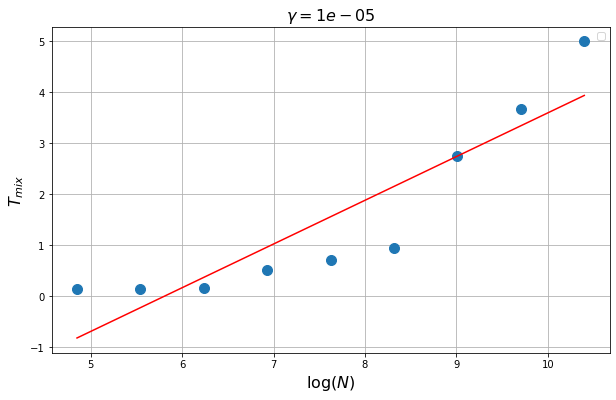

In [17]:
steps_first_gamma = np.array(steps_first_gamma)

plt.figure(figsize = (10, 6))
x = np.log(n_list)
y = steps_first_gamma * time_step_size


plt.plot(x, y,'o', markersize=10)

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.plot(x, m*x + c, 'r')
plt.grid()

plt.legend()
plt.title(f'$\gamma = {gamma}$', fontsize=16)
plt.xlabel('$\log (N)$', fontsize=16)
plt.ylabel('$T_{mix}$', fontsize=16)
plt.show()